In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from skopt import BayesSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
import sys
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
import numpy as np
from imblearn.over_sampling import SMOTE

# Defining train_model function

In [2]:

def train_model(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
    model = RandomForestClassifier()
    param_grid = {
        'n_estimators': [100, 1000, 2000],
        'max_features': [None, 'sqrt', 'log2', 0.5],
        'max_depth': [None, 10, 20, 30, 40, 50, 60],
        'min_samples_split': [2, 5, 10, 20],
        'min_samples_leaf': [1, 2, 4, 8],
        'bootstrap': [True, False]
    }

    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    bayes_search = BayesSearchCV(
    estimator=model,
    search_spaces=param_grid,
    n_iter=20,  # Number of iterations for optimization
    cv=kfold,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
    )
    
    bayes_search.fit(X_train, y_train)
    best_model = bayes_search.best_estimator_
    best_model.fit(X_train, y_train)
    cv_results = bayes_search.cv_results_
    best_index = bayes_search.best_index_
    predictions = best_model.predict(X_test)
    predictions_train = best_model.predict(X_train)
    predictions_2 = best_model.predict_proba(X_test)
    predictions_2_train = best_model.predict_proba(X_train)

    test_accuracy = accuracy_score(y_test, predictions)
    test_precision = precision_score(y_test, predictions, average='macro')
    test_recall = recall_score(y_test, predictions, average='macro')
    test_roc_auc = roc_auc_score(y_test, predictions_2,  multi_class='ovr')
    test_f1 = f1_score(y_test, predictions, average='macro')
    
    train_accuracy = accuracy_score(y_train, predictions_train)
    train_precision = precision_score(y_train, predictions_train, average='macro')
    train_recall = recall_score(y_train, predictions_train, average='macro')
    train_roc_auc = roc_auc_score(y_train, predictions_2_train,  multi_class='ovr')
    train_f1 = f1_score(y_train, predictions_train, average='macro')
    
    metrics_dict = {
        'test_accuracy': test_accuracy,
        'test_precision': test_precision,
        'test_recall': test_recall,
        'test_roc_auc': test_roc_auc,
        'test_f1': test_f1,
        'train_accuracy': train_accuracy,
        'train_precision': train_precision,
        'train_recall': train_recall,
        'train_roc_auc': train_roc_auc,
        'train_f1': train_f1
    }
    
    return metrics_dict, best_model, y_test, X_test, cv_results, best_index

# Main code

In [3]:
# Read dataset
df = pd.read_csv(r'output_combined.csv')
# Prep the dataset
df = df.dropna()
df = df.drop(df.columns[df.columns.str.contains('Unnamed')], axis=1)
df['date'] = pd.to_datetime(df['date'])
df['date'] = df['date'].dt.dayofyear
df = df.drop(df.index[-1])
replacement_dict = {'Non': 0, 'NPF': 1, 'undefined': 2}
df['day.type'] = df['day.type'].replace(replacement_dict)
df_orig = df

# SMOTE

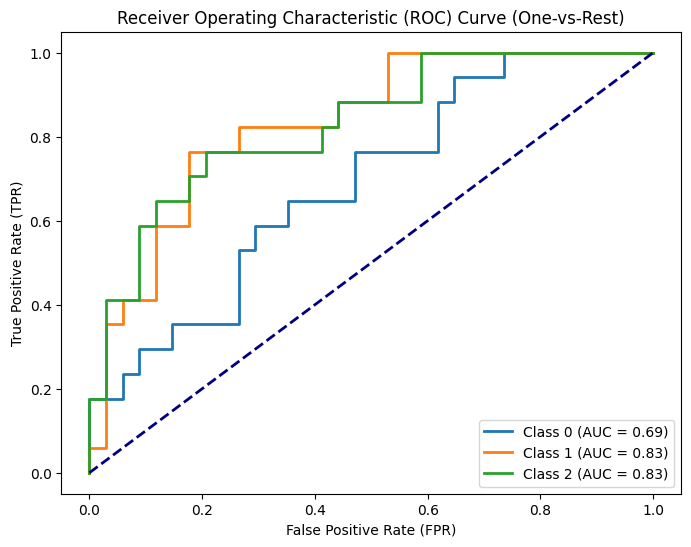

In [8]:

df_selected = df_orig[["pressure", "RH", "temperature", "SRAD", "day.type"]].copy()
df = df_selected
# Split dataset
X = df.drop(columns=["day.type"])
y = df["day.type"]

smote = SMOTE(sampling_strategy='auto')
X, y = smote.fit_resample(X, y)

# Unpack results
metrics_dict, model, y_test, X_test, cv_results, best_index = train_model(X=X, y=y)
cv_results = pd.DataFrame(cv_results)
best_cv_results = cv_results.loc[best_index, :]

# Visualize feature importances
feature_importances = model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Redirect stdout to a file
with open('rf_tuned_smote.txt', 'w') as file:
    sys.stdout = file
    print("Test accuracy", metrics_dict['test_accuracy'])
    print("Test precision", metrics_dict['test_precision'])
    print("Test recall", metrics_dict['test_recall'])
    print("Test roc_auc", metrics_dict['test_roc_auc'])
    print("Test f1", metrics_dict['test_f1'])
    print('-------------------------------------------------------------------------------')
    print("Train accuracy", metrics_dict['train_accuracy'])
    print("Train precision", metrics_dict['train_precision'])
    print("Train recall", metrics_dict['train_recall'])
    print("Train roc_auc", metrics_dict['train_roc_auc'])
    print("Train f1", metrics_dict['train_f1'])
    print('-------------------------------------------------------------------------------')
    print(best_cv_results)
    print('-------------------------------------------------------------------------------')
    print("Feature Importance:")
    print(feature_importance_df)
    # Reset stdout back to the console
    sys.stdout = sys.__stdout__

# Calculate ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

# Convert y_test to one-hot encoding
y_test_onehot = pd.get_dummies(y_test)
# Calculate ROC curve for each class
for i in range(len(model.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_onehot.iloc[:, i], model.predict_proba(X_test)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Plot ROC curves for each class
plt.figure(figsize=(8, 6))
for i in range(len(model.classes_)):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {model.classes_[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve (One-vs-Rest)')
plt.legend(loc='lower right')
# plt.show()
plt.savefig('rf_tuned_ROC_smote.png', dpi=300)

# NORM

c:\Users\Masloriy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Masloriy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


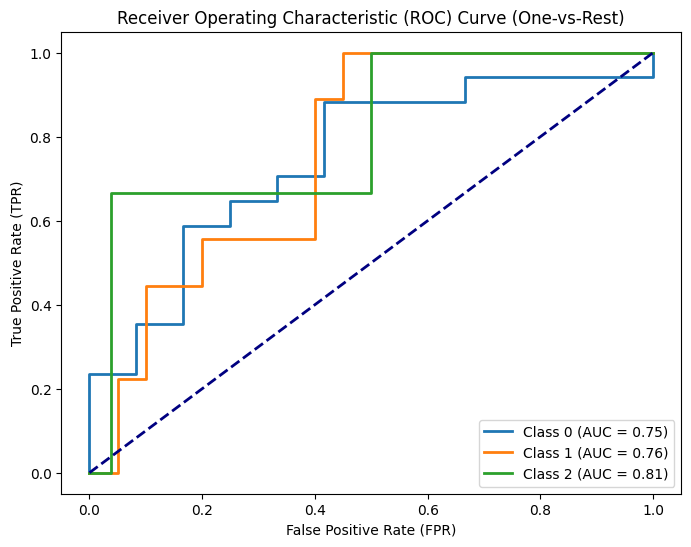

In [5]:

df_selected = df_orig[["pressure", "RH", "temperature", "SRAD", "day.type"]].copy()
df = df_selected
# Split dataset
X = df.drop(columns=["day.type"])
y = df["day.type"]

# Unpack results
metrics_dict, model, y_test, X_test, cv_results, best_index = train_model(X=X, y=y)
cv_results = pd.DataFrame(cv_results)
best_cv_results = cv_results.loc[best_index, :]

# Visualize feature importances
feature_importances = model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Redirect stdout to a file
with open('rf_tuned_norm.txt', 'w') as file:
    sys.stdout = file
    print("Test accuracy", metrics_dict['test_accuracy'])
    print("Test precision", metrics_dict['test_precision'])
    print("Test recall", metrics_dict['test_recall'])
    print("Test roc_auc", metrics_dict['test_roc_auc'])
    print("Test f1", metrics_dict['test_f1'])
    print('-------------------------------------------------------------------------------')
    print("Train accuracy", metrics_dict['train_accuracy'])
    print("Train precision", metrics_dict['train_precision'])
    print("Train recall", metrics_dict['train_recall'])
    print("Train roc_auc", metrics_dict['train_roc_auc'])
    print("Train f1", metrics_dict['train_f1'])
    print('-------------------------------------------------------------------------------')
    print(best_cv_results)
    print('-------------------------------------------------------------------------------')
    print("Feature Importance:")
    print(feature_importance_df)
    # Reset stdout back to the console
    sys.stdout = sys.__stdout__

# Calculate ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

# Convert y_test to one-hot encoding
y_test_onehot = pd.get_dummies(y_test)
# Calculate ROC curve for each class
for i in range(len(model.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_onehot.iloc[:, i], model.predict_proba(X_test)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Plot ROC curves for each class
plt.figure(figsize=(8, 6))
for i in range(len(model.classes_)):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {model.classes_[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve (One-vs-Rest)')
plt.legend(loc='lower right')
# plt.show()
plt.savefig('rf_tuned_ROC_norm.png', dpi=300)

# PM25 AND SO2

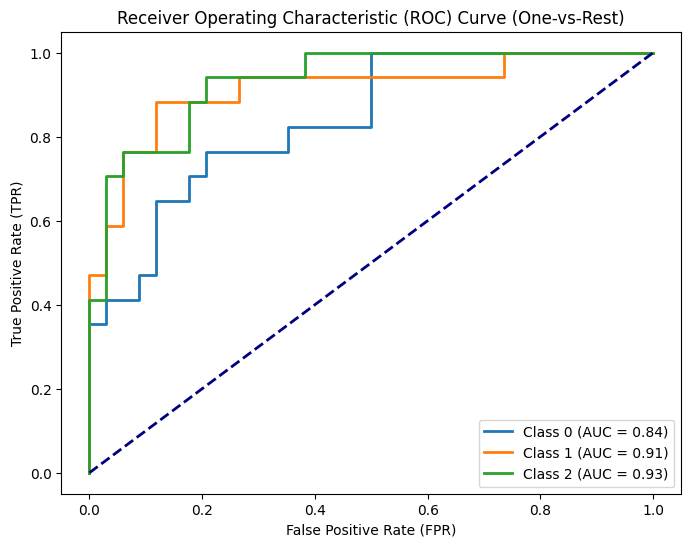

In [7]:

df_selected = df_orig[["pressure", "RH", "temperature", "SRAD", "day.type", 'pm25', 'so2']].copy()
df = df_selected
# Split dataset
X = df.drop(columns=["day.type"])
y = df["day.type"]

smote = SMOTE(sampling_strategy='auto')
X, y = smote.fit_resample(X, y)

# Unpack results
metrics_dict, model, y_test, X_test, cv_results, best_index = train_model(X=X, y=y)
cv_results = pd.DataFrame(cv_results)
best_cv_results = cv_results.loc[best_index, :]

# Visualize feature importances
feature_importances = model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Redirect stdout to a file
with open('rf_tuned_smote_all.txt', 'w') as file:
    sys.stdout = file
    print("Test accuracy", metrics_dict['test_accuracy'])
    print("Test precision", metrics_dict['test_precision'])
    print("Test recall", metrics_dict['test_recall'])
    print("Test roc_auc", metrics_dict['test_roc_auc'])
    print("Test f1", metrics_dict['test_f1'])
    print('-------------------------------------------------------------------------------')
    print("Train accuracy", metrics_dict['train_accuracy'])
    print("Train precision", metrics_dict['train_precision'])
    print("Train recall", metrics_dict['train_recall'])
    print("Train roc_auc", metrics_dict['train_roc_auc'])
    print("Train f1", metrics_dict['train_f1'])
    print('-------------------------------------------------------------------------------')
    print(best_cv_results)
    print('-------------------------------------------------------------------------------')
    print("Feature Importance:")
    print(feature_importance_df)
    # Reset stdout back to the console
    sys.stdout = sys.__stdout__

# Calculate ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

# Convert y_test to one-hot encoding
y_test_onehot = pd.get_dummies(y_test)
# Calculate ROC curve for each class
for i in range(len(model.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_onehot.iloc[:, i], model.predict_proba(X_test)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Plot ROC curves for each class
plt.figure(figsize=(8, 6))
for i in range(len(model.classes_)):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {model.classes_[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve (One-vs-Rest)')
plt.legend(loc='lower right')
# plt.show()
plt.savefig('rf_tuned_ROC_smote_all.png', dpi=300)